# Fashion-Dataset
In dieser Demo schauen wir uns am Beispiel des FashionMNIST Datensatz an, wie wir unsere eigene Modelle in PyTorch bauen und trainieren können.

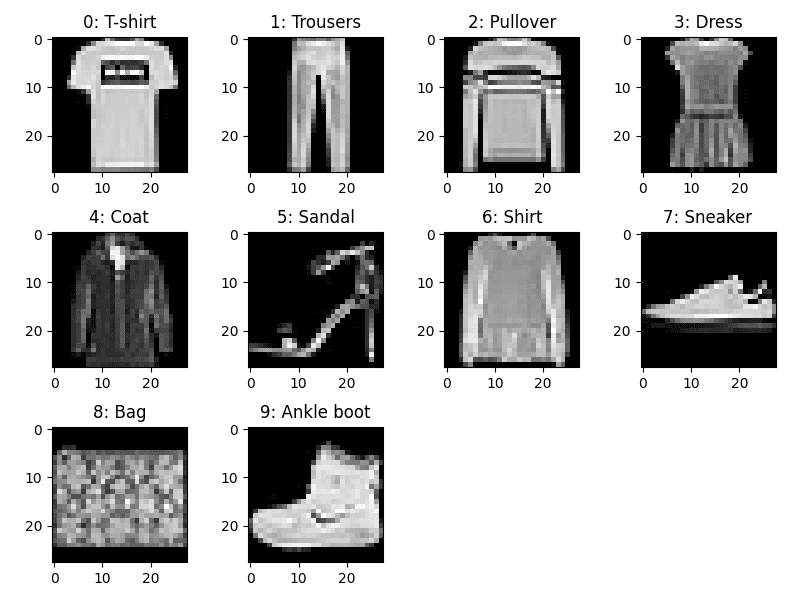

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 100
num_classes = 10
lr = 0.001 # Lernrate
epochs = 8

In [3]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%
1.5%

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [4]:
# diesmal teilen wir das Trainingsset noch in ein Validierungsset
train_set, val_set = torch.utils.data.random_split(train_data,
                                                   [
                                                    int(0.8 * len(train_data)),
                                                    int(0.2 * len(train_data))
                                                    ])


train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=len(test_data))

## LeNet5
... ist ein **Convolutional Neural Network (CNN)*** aus dem Jahr 1998 und gilt als inoffizieller Vorgänger vieler Modelle, darunter das recht bekannte **AlexNet**.

\* CNNs sind Netzwerke, die, außer dem linearen Teil auch einen Teil bestehend aus Filtern/Kerneln, die wie Fenster über den Input (z.B. Bilder) gleiten und in einer Faltungsoperation selbstständig Features extrahieren können. Besonders wichtig sind sie bei der Bildverarbeitung und -klassifizierung.

In [5]:
class LeNet5(nn.Module):

  def __init__(self, num_channels=1, num_classes=10):
    super().__init__()
    # https://en.wikipedia.org/wiki/LeNet
    # CNN-Teil
    self.base1 = nn.Sequential(
        # 1 input channel, 6 output channels (feature maps) of 5x5 dimension
        nn.Conv2d(num_channels, 6, 5, padding=2),
        nn.Sigmoid(),
        nn.MaxPool2d(2, stride=2)
    )
    self.base2 = nn.Sequential(
        # 6 feature maps from the above conv layer, 16 output channels of 5x5
        nn.Conv2d(6, 16, 5),
        nn.Sigmoid(),
        nn.MaxPool2d(2, stride=2)
    )
    # linearer Teil
    self.base3 = nn.Sequential(
        nn.Flatten(),
        # 5x5x16 = 400
        nn.Linear(400, 120),
        nn.Sigmoid(),
        nn.Linear(120, 84),
        nn.Sigmoid(),
        nn.Linear(84, num_classes)
    )

  def forward(self, x):
    x = self.base1(x)
    x = self.base2(x)
    x = self.base3(x)
    return x

In [6]:
model = LeNet5()

# Kostenfunktion
cost_function = nn.CrossEntropyLoss()

# Optimierungsalgorithmus
optim = torch.optim.Adam(model.parameters(), lr=lr)

In [7]:
from sklearn.metrics import accuracy_score

# wir werden diese Funktion im Training nutzen
def eval_model_performance(ds, model):
  # Dataloader für die Evaluierung
  d_loader = DataLoader(dataset=ds, batch_size=len(ds))
  cost_function = nn.CrossEntropyLoss()
  model.eval()

  with torch.no_grad():
    for x, y in d_loader:
      raw_y_preds = model(x)
    
    y_class_preds = raw_y_preds.argmax(dim=1)
    eval_cost = cost_function(raw_y_preds, y).item()
  
  # Model zurück in den Trainingsmodus setzen
  model.train()
  eval_acc = accuracy_score(y_pred=y_class_preds, y_true=y)

  return eval_cost, eval_acc

In [8]:
# nach jeder (every) Epoche soll ein Zwischenstand ausgegeben werden
every = 1
# Listen für die Kosten und die Genauigkeit, um das Training zu verfolgen
train_costs, train_accs = [], []
val_costs, val_accs = [], []

# Training
for epoch in range(epochs):
  for x_batch, y_batch in train_loader:
    y_preds = model(x_batch)
    cost = cost_function(y_preds, y_batch)
    optim.zero_grad()
    cost.backward()
    optim.step()
  
  if epoch % every == 0 and epoch != 0:
    # Validation
    train_cost, train_acc = eval_model_performance(train_set, model)
    val_cost, val_acc = eval_model_performance(val_set, model)
    # Metriken speichern
    train_costs.append(train_cost)
    train_accs.append(train_acc)
    val_costs.append(val_cost)
    val_accs.append(val_acc)
    print(f"epoch {epoch}, train cost: {train_cost}, train accuracy: {train_acc}")
    print(f"epoch {epoch}, val cost: {val_cost}, val accuracy: {val_acc}")
    print(10*"---")

epoch 1, train cost: 0.685038149356842, train accuracy: 0.7310833333333333
epoch 1, val cost: 0.6849207282066345, val accuracy: 0.7360833333333333
------------------------------
epoch 2, train cost: 0.5821232199668884, train accuracy: 0.775125
epoch 2, val cost: 0.5810760259628296, val accuracy: 0.7785833333333333
------------------------------
epoch 3, train cost: 0.5310564637184143, train accuracy: 0.8019375
epoch 3, val cost: 0.5304899215698242, val accuracy: 0.801
------------------------------
epoch 4, train cost: 0.49401944875717163, train accuracy: 0.8175416666666667
epoch 4, val cost: 0.4954509139060974, val accuracy: 0.818
------------------------------
epoch 5, train cost: 0.4601382315158844, train accuracy: 0.8319375
epoch 5, val cost: 0.46363532543182373, val accuracy: 0.8289166666666666
------------------------------
epoch 6, train cost: 0.4436308741569519, train accuracy: 0.8372916666666667
epoch 6, val cost: 0.44815245270729065, val accuracy: 0.8348333333333333
---------

### Warum Valdierung?
Wir möchten unser Modell bereits während des Trainings überwachen und sehen, ob es evtl. overfitted. Das ist bspw. der Fall, wenn die Trainings- und Validierungsgenauigkeit zu weit auseinander liegt. Wir validieren stehts auf einem unabhängigen Datensatz (daher anfangs der split) und optimieren nicht über die Gradienten des Validierungsdatensatzen (daher `no_grad` in der Evaluierungsfunktion `eval_model_performance`).

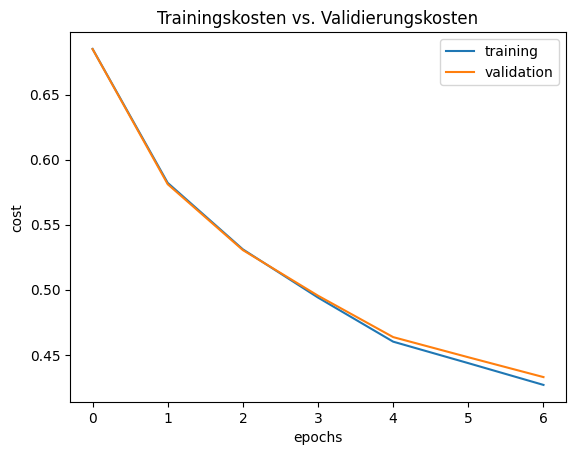

In [9]:
plt.plot(range(len(train_costs)), train_costs, label="training")
plt.plot(range(len(val_costs)), val_costs, label="validation")
plt.xlabel("epochs")
plt.ylabel("cost")
plt.legend(loc="upper right")
plt.title("Trainingskosten vs. Validierungskosten")
plt.show()

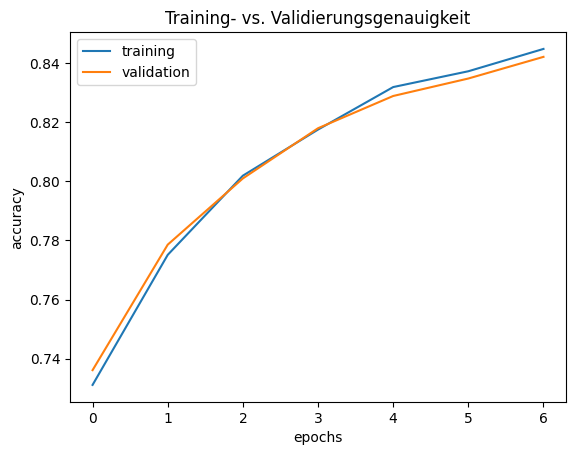

In [10]:
plt.plot(range(len(train_accs)), train_accs, label="training")
plt.plot(range(len(val_accs)), val_accs, label="validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="upper left")
plt.title("Training- vs. Validierungsgenauigkeit")
plt.show()

In [11]:
# der finale Test auf dem Testset
test_cost, test_acc = eval_model_performance(test_data, model)
print("test cost:", test_cost)
print("test accuracy:", test_acc)

test cost: 0.4595796465873718
test accuracy: 0.833


83,3 % Genauigkeit ist nicht schlecht!

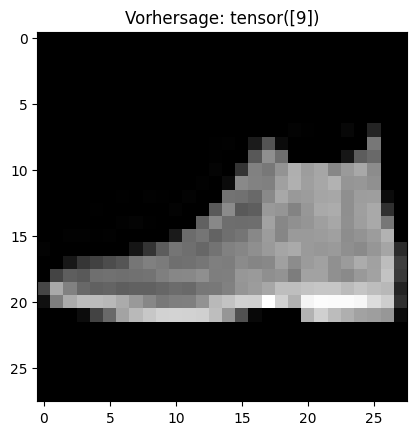

In [18]:
test_loader = DataLoader(dataset=test_data, batch_size=1)
with torch.no_grad():
    for img, label in test_loader:
        out = model(img)
        prediction = out.argmax(dim=1)
        break
# [0][0], weil das Bild Dimensionen [batch x channel x H x W] hat
plt.imshow(img[0][0], cmap="gray")
plt.title(f"Vorhersage: {prediction}")
plt.show()